# MATMUL benchmark

Doba výpočtu bodového algoritmu:
$$
    T \approx 2 n^3 T_{RAM}.
$$

Doba výpočtu blokového algoritmu ($b$ - velikost bloku)
$$
    T \approx \left(3 b^2 T_{RAM} + 2 b^3 T_{Cache}\right) \left(\frac{n}{b}\right)^3 = n^3 \left( \frac{3T_{RAM}}{b} + 2 T_{Cache}\right).
$$


In [1]:
function testmatrix(n)
    A = zeros(n,n)
    for i=1:n, j=1:n
        A[i,j] = i - j
    end
    return A
end;

In [2]:
function matmul_jki!(C, A, B)
    assert( size(A,2) == size(B,1) )
    assert( size(A,1) == size(C,1) && size(B,2) == size(C,2) )
 
    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                @inbounds C[i,j] += A[i,k] * B[k,j]
            end
        end
    end
end;

In [3]:
function matmul_kji!(C, A, B)
    assert( size(A,2) == size(B,1) )
    assert( size(A,1) == size(C,1) && size(B,2) == size(C,2) )
 
    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    
    for k=1:size(A,2)
        for j=1:size(B,2)
            for i=1:size(A,1)
                @inbounds C[i,j] += A[i,k] * B[k,j]
            end
        end
    end
end;

In [4]:
function matmul_ijk!(C, A, B)
    assert( size(A,2) == size(B,1) )
    assert( size(A,1) == size(C,1) && size(B,2) == size(C,2) )
 
    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                @inbounds C[i,j] += A[i,k] * B[k,j]
            end
        end
    end
end;

In [5]:
function matmul_block!(C, A, B)
    assert( size(A,2) == size(B,1) )
    assert( size(A,1) == size(C,1) && size(B,2) == size(C,2) )
 
    block = 51
    
    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    
    for k=1:block:size(A,2)
        kend = min(k+block-1, size(A,2))
        
        for j=1:block:size(B,2)
            jend = min(j+block-1, size(B,2))
            
            for i=1:block:size(A,1)
                iend = min(i+block-1, size(A,1))

                for kk=k:kend
                    for jj=j:jend
                        for ii=i:iend
                            @inbounds C[ii,jj] += A[ii,kk] * B[kk,jj]
                        end
                    end
                end

            end
        end
    end
end;

In [6]:
function matmul_openblas!(C, A, B)
    CblasColMajor = 102
    CblasNoTrans = 111
    ccall( (:cblas_dgemm, "libopenblas"),
    
    Void, 
    (Clonglong, Clonglong, Clonglong, Clonglong, Clonglong, Clonglong, 
    Cdouble, Ptr{Cdouble}, Clonglong, 
    Ptr{Cdouble}, Clonglong, 
    Cdouble, Ptr{Cdouble}, Clonglong),
    
    CblasColMajor, CblasNoTrans, CblasNoTrans,
    size(A,1), size(A,2), size(B,2),
    1.0, A, size(A,1),
    B, size(B,1),
    0.0, C, size(C,1)
        )
end;

In [7]:
A10 = testmatrix(10);
B10 = copy(A10);
C10 = copy(A10);

@time matmul_ijk!(C10, A10, B10);
@time matmul_jki!(C10, A10, B10);
@time matmul_kji!(C10, A10, B10);
@time matmul_block!(C10, A10, B10);
@time A_mul_B!(C10, A10, B10);
@time matmul_openblas!(C10, A10, B10)

  0.026898 seconds (7.65 k allocations: 392.451 KiB)
  0.032429 seconds (7.31 k allocations: 370.704 KiB)
  0.033438 seconds (7.31 k allocations: 370.688 KiB)
  0.055026 seconds (14.90 k allocations: 709.413 KiB)
  0.428469 seconds (236.68 k allocations: 11.185 MiB)
  0.005111 seconds (3.16 k allocations: 174.452 KiB)


In [8]:
function bench(fun)
    n = [10, 50, 100, 200, 500, 1000, 1500, 2000, 2500]
    t  = zeros(Float64, size(n))
    
    for i=1:size(n,1)
        A = testmatrix(n[i])
        B = copy(A)
        C = copy(A)
        
        t1 = time_ns()
        fun(A, B, C)
        t[i] = (time_ns() - t1) * 1.e-9
    end
    return t, n
end

bench (generic function with 1 method)

In [9]:
t_ijk, n = bench(matmul_ijk!);

In [10]:
t_jki, n = bench(matmul_jki!);

In [11]:
t_kji, n = bench(matmul_kji!);

In [12]:
t_block, n = bench(matmul_block!);

In [13]:
t_builtin, n = bench(A_mul_B!);

In [14]:
t_openblas, n = bench(matmul_openblas!);

In [15]:
using PyPlot;

In [16]:
mflops(t, n) = [ 1.e-6 * 2 * float(n[i])^3 / t[i] for i in 1:size(t,1)]

mflops (generic function with 1 method)

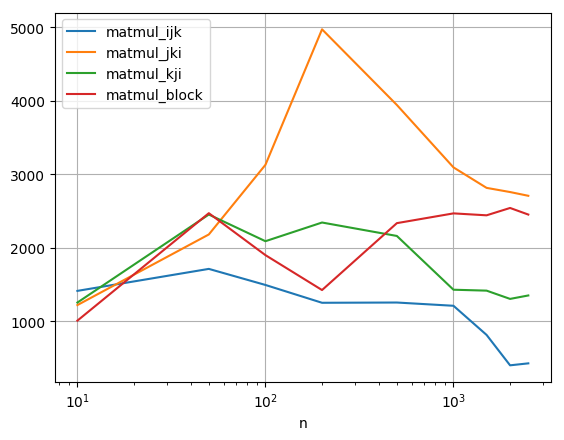

In [17]:
semilogx(n, mflops(t_ijk,n), label="matmul_ijk");
semilogx(n, mflops(t_jki,n), label="matmul_jki");
semilogx(n, mflops(t_kji,n), label="matmul_kji");
semilogx(n, mflops(t_block,n), label="matmul_block");
#semilogx(n, mflops(t_builtin,n), label="matmul_builtin");
#semilogx(n, mflops(t_openblas,n), label="matmul_openblas");
legend(loc="upper left"); xlabel("n"); ylabel
grid(true);

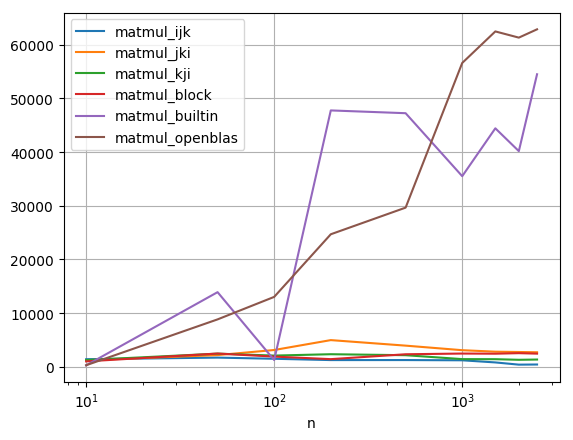

In [18]:
semilogx(n, mflops(t_ijk,n), label="matmul_ijk");
semilogx(n, mflops(t_jki,n), label="matmul_jki");
semilogx(n, mflops(t_kji,n), label="matmul_kji");
semilogx(n, mflops(t_block,n), label="matmul_block");
semilogx(n, mflops(t_builtin,n), label="matmul_builtin");
semilogx(n, mflops(t_openblas,n), label="matmul_openblas");
legend(loc="upper left"); xlabel("n"); ylabel
grid(true);